In [1]:
import pickle
import tempfile
import pydot
import graphviz
import numpy as np
import tensorflow as tf
from get_data import *
from model import *
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
MAX_SEQ_LEN = 42
EMBEDDING_DIM = 300
VOCAB_SIZE = 20000

In [4]:
data = read_data()
train_data = data[:3]
test_data = data[3:]

In [5]:
train_data, embed_matrix = preprocess_traindata(train_data, MAX_SEQ_LEN, EMBEDDING_DIM, VOCAB_SIZE)

Non labelled: 785
Contradiction: 183187
Neutral: 182764
Entailment: 183416


In [6]:
train_data[0].shape

(549367, 42)

In [7]:
train_data[1].shape

(549367, 42)

In [8]:
train_data[2].shape

(549367, 3)

In [9]:
l2 = 0.00002
premise = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
hypothesis = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
prediction = create_Inner_Attention_model(premise, hypothesis, embed_matrix, l2, EMBEDDING_DIM, MAX_SEQ_LEN, baseline=False)

# Define the complete model
model = tf.keras.models.Model(inputs=[premise, hypothesis], outputs=prediction)

# Choosing an optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.005)

# Compile the model and print out the model summary
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [10]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

_, tmpfn = tempfile.mkstemp()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)

callbacks = [model_checkpoint, learning_rate_reduction, early_stopping]

In [11]:
# Train the model
history = model.fit(x=[train_data[0], train_data[1]], y=train_data[2], batch_size=1024, epochs=75, validation_split=0.02, callbacks=callbacks)

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./figures/model_acc_0.00002_0.25_1_100_300D_11.png')
plt.show()

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./figures/model_loss_0.00002_0.25_1_100_300D_11.png')
plt.show()

In [14]:
test_data = data[3:]
test_data = preprocess_testdata(test_data, MAX_SEQ_LEN)

Non labelled: 176
Contradiction: 3237
Neutral: 3219
Entailment: 3368


In [15]:
loss, accuracy = model.evaluate(x=[test_data[0], test_data[1]], y=test_data[2], batch_size=512)
print("Test Loss: {:.2f}, Test Accuracy: {:.2f}%\n".format(loss, (accuracy*100)))

In [16]:
Y_pred = model.predict([test_data[0], test_data[1]])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(test_data[2], axis=1)

In [17]:
Y_test

array([1, 2, 0, ..., 0, 2, 1], dtype=int64)

In [18]:
Y_pred

array([1, 2, 0, ..., 0, 2, 1], dtype=int64)

In [19]:
plt.figure(figsize=(8, 6))
ticks = ['Contradiction', 'Neutral', 'Entailment']
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
# plt.savefig('./figures/model_conf_0.00002_0.25_1_100_300D_11.png')

In [20]:
plt.figure(figsize=(8, 6))
report = classification_report(Y_test, Y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :3].T, annot=True)
# plt.savefig('./figures/model_metrics_0.00002_0.25_1_100_300D_11.png')

In [21]:
tf.keras.models.save_model(model, './Trained Models/0.00002_0.25_1_100_300D_11.h5')

In [22]:
model1 = tf.keras.models.load_model('./Trained Models/0.00002_0.25_1_100_300D_Inner.h5', 
                                    custom_objects={'InnerAttention':InnerAttention, 
                                                    'L2':tf.keras.regularizers.l2(l2=0.00002)})

In [23]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 300)      7802100     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 42, 300)      90300       embedding_1[0][0]            

In [24]:
test_data = data[3:]
test_data = preprocess_testdata(test_data, MAX_SEQ_LEN)

Non labelled: 176
Contradiction: 3237
Neutral: 3219
Entailment: 3368


In [25]:
loss, accuracy = model1.evaluate(x=[test_data[0], test_data[1]], y=test_data[2], batch_size=1024)
print("Test Loss: {:.2f}, Test Accuracy: {:.2f}%\n".format(loss, (accuracy*100)))

10/10 [==============================] - 6s 113ms/step - loss: 0.5277 - accuracy: 0.8285
Test Loss: 0.53, Test Accuracy: 82.85%



In [26]:
Y_pred = model1.predict([test_data[0], test_data[1]])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(test_data[2], axis=1)

In [27]:
confusion_matrix(Y_test, Y_pred)

array([[2624,  337,  276],
       [ 256, 2524,  439],
       [ 118,  259, 2991]], dtype=int64)

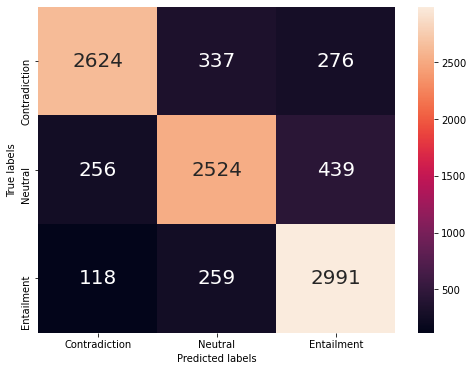

In [28]:
plt.figure(figsize=(8, 6))
ticks = ['Contradiction', 'Neutral', 'Entailment']
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks, annot_kws={"size":20})
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.savefig('./figures/best_model_conf.png')

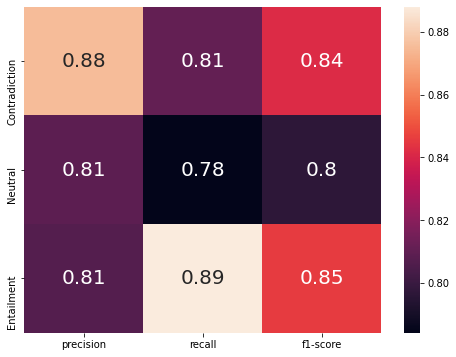

In [29]:
plt.figure(figsize=(8, 6))
report = classification_report(Y_test, Y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :3].T, annot=True, annot_kws={"size":20})
plt.savefig('./figures/best_model_metrics.png')

In [30]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)